# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup posts on a variety of topics. You'll train classifiers to distinguish posts by topics inferred from the text. Whereas with digit classification, where each input is relatively dense (represented as a 28x28 matrix of pixels, many of which are non-zero), here each document is relatively sparse (represented as a bag-of-words). Only a few words of the total vocabulary are active in any given document. The assumption is that a label depends only on the count of words, not their order.

The `sklearn` documentation on feature extraction may be useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on Slack, but <b> please prepare your own write-up with your own code. </b>

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

import nltk

Load the data, stripping out metadata so that only textual features will be used, and restricting documents to 4 specific topics. By default, newsgroups data is split into training and test sets, but here the test set gets further split into development and test sets.  (If you remove the categories argument from the fetch function calls, you'd get documents from all 20 topics.)

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test  = fetch_20newsgroups(subset='test',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

num_test = int(len(newsgroups_test.target) / 2)
test_data, test_labels   = newsgroups_test.data[num_test:], newsgroups_test.target[num_test:]
dev_data, dev_labels     = newsgroups_test.data[:num_test], newsgroups_test.target[:num_test]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print('training label shape:', train_labels.shape)
print('dev label shape:',      dev_labels.shape)
print('test label shape:',     test_labels.shape)
print('labels names:',         newsgroups_train.target_names)

training label shape: (2034,)
dev label shape: (676,)
test label shape: (677,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


### Part 1:

For each of the first 5 training examples, print the text of the message along with the label.

In [3]:
def P1(num_examples=5):

    ### STUDENT START ###
    # For every example in the training set upto num_examples:
    for i in range(num_examples):
        print('TRAINING EXAMPLE:', i)
        print('\nLabel: "{0}."\n'.format(newsgroups_train.target_names[train_labels[i]]))
        print('Text of the message:\n', train_data[i])
        print('---------------------------------------\n')
    ### STUDENT END ###

P1(5)

TRAINING EXAMPLE: 0

Label: "comp.graphics."

Text of the message:
 Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych
---------------------------------------

TRAINING EXAMPLE: 1

Label: "talk.religion.misc."

Text of the message:
 

Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional m

### Part 2:

Transform the training data into a matrix of **word** unigram feature vectors.  What is the size of the vocabulary? What is the average number of non-zero features per example?  What is the fraction of the non-zero entries in the matrix?  What are the 0th and last feature strings (in alphabetical order)?<br/>
_Use `CountVectorization` and its `.fit_transform` method.  Use `.nnz` and `.shape` attributes, and `.get_feature_names` method._

Now transform the training data into a matrix of **word** unigram feature vectors using your own vocabulary with these 4 words: ["atheism", "graphics", "space", "religion"].  Confirm the size of the vocabulary. What is the average number of non-zero features per example?<br/>
_Use `CountVectorization(vocabulary=...)` and its `.transform` method._

Now transform the training data into a matrix of **character** bigram and trigram feature vectors.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(analyzer=..., ngram_range=...)` and its `.fit_transform` method._

Now transform the training data into a matrix of **word** unigram feature vectors and prune words that appear in fewer than 10 documents.  What is the size of the vocabulary?<br/>
_Use `CountVectorization(min_df=...)` and its `.fit_transform` method._

Now again transform the training data into a matrix of **word** unigram feature vectors. What is the fraction of words in the development vocabulary that is missing from the training vocabulary?<br/>
_Hint: Build vocabularies for both train and dev and look at the size of the difference._

Notes:
* `.fit_transform` makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").
* `.fit_transform` and `.transform` return sparse matrix objects.  See about them at http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html.  

In [4]:
def P2():
    ### STUDENT START ###
    # 2.a. Transform the training data into a matrix of word unigram feature vectors
    
    cv = CountVectorizer()
    feature_vectors = cv.fit_transform(newsgroups_train.data)
    
    # size of the vocabulary
    print ('2.a.1) The size of the vocabulary is {0}.'.format(feature_vectors.shape[1]))
    
    # Average number of non-zero features per example
    print ('2.a.2) The average number of non-zero features per example is {0:.3f}.'.format(feature_vectors.nnz / float(feature_vectors.shape[0])))
    
    # fraction of the non-zero entries in the matrix
    print ('2.a.3) {0:.3f}% of the entries in the matrix are non-zero.'.\
        format(100*float(feature_vectors.nnz) / (feature_vectors.shape[0] *
                                                 feature_vectors.shape[1])))
    
    # 0th and last feature strings (in alphabetical order)
    feature_strings = cv.fit_transform(train_data)
    feature_strings = cv.get_feature_names()
    feature_strings.sort()
    print ('2.a.4) The 0th (1st) feature string is "{0}"'.format(feature_strings[0]))
    print ('\tThe last feature string is "{0}"'.format(feature_strings[-1]))
    
    #2.b. Transform the training data into a matrix of word unigram feature vectors using your own vocabulary
    voc = ["atheism", "graphics", "space", "religion"]
    cv_new_vector = CountVectorizer(vocabulary=voc)
    own_vocab = cv_new_vector.transform(raw_documents=newsgroups_train.data)
    
    # 2.b.1. size of the vocabulary
    print('\n2.b.1) The size of own vocabulary is {0}.'.format(own_vocab.shape))
    
    # 2.b.2. What is the average number of non-zero features per example?
    print ('2.b.2) The average number of non-zero features per example is {0:.3f}.'.format(own_vocab.nnz / float(own_vocab.shape[0])))
    
    #2.c. Transforming training data into a matrix of character bigram and trigram feature vectors
    cv_char = CountVectorizer(analyzer='char', ngram_range=(2, 3))
    biandtrigram_vector = cv_char.fit_transform(newsgroups_train.data)
    # size of the vocabulary
    print('\n2.c) The size of vocabulary bigram/trigram is {0}.'.format(biandtrigram_vector.shape[1]))
    
    # 2.d. Transform the training data into a matrix of word unigram feature vectors and prune words that appear in fewer than 10 documents.
    cv_prune = CountVectorizer(min_df=10)
    prune_vector = cv_prune.fit_transform(newsgroups_train.data)
    # size of the vocabulary
    print('\n2.d) The size of vocabulary when pruning words that appear in fewer than 10 documents is {0}.'.format(prune_vector.shape[1]))
    
    # 2.e. Transform the training data into a matrix of word unigram feature vectors. 
    # Finding fraction of words in the development vocabulary that is missing from the training vocabulary?
    cv = CountVectorizer()
    print ('\n2.e) {0:.2f}% of the words in the dev data are missing from the vocabulary ' \
          'based on the training data.'.\
        format(100*float(len(set(cv.fit(raw_documents=dev_data).get_feature_names()) -
                             set(cv.fit(raw_documents=train_data).get_feature_names()))) /
               len(set(cv.fit(raw_documents=dev_data).get_feature_names()))))
    
    ### STUDENT END ###

P2()

2.a.1) The size of the vocabulary is 26879.
2.a.2) The average number of non-zero features per example is 96.706.
2.a.3) 0.360% of the entries in the matrix are non-zero.
2.a.4) The 0th (1st) feature string is "00"
	The last feature string is "zyxel"

2.b.1) The size of own vocabulary is (2034, 4).
2.b.2) The average number of non-zero features per example is 0.268.

2.c) The size of vocabulary bigram/trigram is 35478.

2.d) The size of vocabulary when pruning words that appear in fewer than 10 documents is 3064.

2.e) 24.79% of the words in the dev data are missing from the vocabulary based on the training data.


### Part 3:

Transform the training and development data to matrices of word unigram feature vectors.

1. Produce several k-Nearest Neigbors models by varying k, including one with k set to optimize f1 score.  For each model, show the k value and f1 score.
1. Produce several Naive Bayes models by varying smoothing (alpha), including one with alpha set approximately to optimize f1 score.  For each model, show the alpha value and f1 score.
1. Produce several Logistic Regression models by varying L2 regularization strength (C), including one with C set approximately to optimize f1 score.  For each model, show the C value, f1 score, and sum of squared weights for each topic.

* Why doesn't k-Nearest Neighbors work well for this problem?
* Why doesn't Logistic Regression work as well as Naive Bayes does?
* What is the relationship between logistic regression's sum of squared weights vs. C value?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer` and its `.fit_transform` and `.transform` methods to transform data.
* You can use `KNeighborsClassifier(...)` to produce a k-Nearest Neighbors model.
* You can use `MultinomialNB(...)` to produce a Naive Bayes model.
* You can use `LogisticRegression(C=..., solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.

In [5]:
def P3():
### STUDENT START ###
    # Preparing data
    
    cv = CountVectorizer()
    transformed_train_data = cv.fit_transform(train_data)
    transformed_dev_data = cv.transform(dev_data)

    # K Nearest Neighbors
    # Finding optimal k
    num = range(1, len(dev_data) + 1) 
    num_neighbors = {'n_neighbors': num}                                      
    knn_clf = KNeighborsClassifier()
    clf = GridSearchCV(knn_clf, num_neighbors)                  
    clf.fit(transformed_train_data, train_labels)
    print ('Optimal k for K Nearest Neighbors:', clf.best_params_)

    # Calculating f1 score for optimal k
    knn_clf = KNeighborsClassifier(n_neighbors = clf.best_params_['n_neighbors'])
    knn_clf.fit(transformed_train_data, train_labels)
    knn_clf_preds = knn_clf.predict(transformed_dev_data)
    print ('KNN f1 score for k = {0} is {1}'.format(clf.best_params_['n_neighbors'], metrics.f1_score(y_true = dev_labels, y_pred = knn_clf_preds, average="macro")))
    
    # Multinomial NB
    # Finding Optimal alpha
    alphas = {'alpha': [0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
    mnb_clf = MultinomialNB()
    clf = GridSearchCV(mnb_clf, alphas)
    clf.fit(transformed_train_data, train_labels)
    print ('\nOptimal alpha for MultinimialNB =', clf.best_params_)
    
    # Calculating F1 score for optimal alpha
    mnb_clf = MultinomialNB(alpha = clf.best_params_['alpha'])
    mnb_clf.fit(transformed_train_data, train_labels)
    mnb_clf_preds = mnb_clf.predict(transformed_dev_data)
    print ('MultinomialNB f1 score for alpha = {0} is {1}'.format(clf.best_params_['alpha'], metrics.f1_score(y_true = dev_labels, y_pred = mnb_clf_preds, average="macro")))
    
    # Logistic Regression
    listofCs = [0.0001, 0.001, 0.01, 0.1, 1, 2, 5, 10]
    Cs = {'C': listofCs}

    # Calculating optimal C for Logistic Regression
    logit_clf = LogisticRegression(penalty = 'l2', solver='liblinear')
    clf = GridSearchCV(logit_clf, Cs)
    clf.fit(transformed_train_data, train_labels)
    print ('\nOptimal C for Logistic Regression =', clf.best_params_)
    
    # Calculating F1 score for optimal C
    logit_clf = LogisticRegression(penalty = 'l2', C = clf.best_params_['C'], solver='liblinear')
    logit_clf.fit(transformed_train_data, train_labels)
    logit_clf_preds = logit_clf.predict(transformed_dev_data)
    print ('Logistic Regression f1 Score for C = {0} is {1}'.format(clf.best_params_['C'], metrics.f1_score(y_true = dev_labels, y_pred = logit_clf_preds, average="macro")))

    # Printing sum of squared weights for each class
    print (" ")
    for c in listofCs:
        logit_clf = LogisticRegression(penalty = 'l2', C = c, solver='liblinear')
        logit_clf.fit(transformed_train_data, train_labels)
        logit_clf_preds = logit_clf.predict(transformed_dev_data)
     
        print ("C setting:", c, ";\tSum of Squared weights:\t", np.sum(logit_clf.coef_**2, axis=1))
    
### STUDENT END ###

P3()

Optimal k for K Nearest Neighbors: {'n_neighbors': 183}
KNN f1 score for k = 183 is 0.3817943215599501

Optimal alpha for MultinimialNB = {'alpha': 0.01}
MultinomialNB f1 score for alpha = 0.01 is 0.7552894198013128

Optimal C for Logistic Regression = {'C': 1}
Logistic Regression f1 Score for C = 1 is 0.6793260443571856
 
C setting: 0.0001 ;	Sum of Squared weights:	 [0.00770175 0.0119412  0.00943508 0.00910284]
C setting: 0.001 ;	Sum of Squared weights:	 [0.16509345 0.20095275 0.18067094 0.18724278]
C setting: 0.01 ;	Sum of Squared weights:	 [2.54147304 2.93970937 2.8624689  2.25002871]
C setting: 0.1 ;	Sum of Squared weights:	 [27.13302077 24.65720361 27.45877564 23.03204454]
C setting: 1 ;	Sum of Squared weights:	 [167.00232259 130.87175341 157.96823195 145.74701688]
C setting: 2 ;	Sum of Squared weights:	 [257.55917756 197.89337243 239.8232827  226.68539635]
C setting: 5 ;	Sum of Squared weights:	 [422.87211087 322.85458126 389.86806642 377.93371171]
C setting: 10 ;	Sum of Squared 

ANSWER:

**a. Why doesn't k-Nearest Neighbors work well for this problem?**

- K nearest neighbors uses values of features to calculate distances between observations. In this case the words in the documents are used as features. As found in # 2.e above, almost 25% of the words in the dev dataset are not there in the vocabulary. This mismatch in features results in poorer performance by K nearest neighbors model.

**b.Why doesn't Logistic Regression work as well as Naive Bayes does?**

- In this case, Logistic regression does not perform as well as Naive Bayes because the number of observations is low. If training examples were larger then Logistic regression would have been better. In this case the observations are lesser than the number of features

**c. What is the relationship between logistic regression's sum of squared weights vs. C value?**

- C is the inverse of regularization strength, smaller value of C results in stronger regularization and hence smaller weights. So as C goes smaller the sum of the weights becomes smaller.

### Part 4:

Transform the data to a matrix of word **bigram** feature vectors.  Produce a Logistic Regression model.  For each topic, find the 5 features with the largest weights (that's 20 features in total).  Show a 20 row (features) x 4 column (topics) table of the weights.

Do you see any surprising features in this table?

Notes:
* Train on the transformed training data.
* You can use `CountVectorizer` and its `.fit_transform` method to transform data.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a Logistic Regression model.
* You can use `LogisticRegression`'s `.coef_` method to get weights for each topic.
* You can use `np.argsort` to get indices sorted by element value. 

In [6]:
def P4(cv, summary):
    ### STUDENT START ###
    print (summary)
    transformed_train_data = cv.fit_transform(train_data)
    
    # The ‘liblinear’ solver supports both L1 and L2 regularization, with a dual formulation only for the L2 penalty
    logit_model = LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")
    logit_model.fit(transformed_train_data, train_labels)
    
    sortedIndices = np.argsort(np.absolute(logit_model.coef_), axis = 1)
    
    num_of_features = 5
    feature_names = np.array(cv.get_feature_names())
    
    print ("> Top 5 features per class with the largest weights")
    for i in range(logit_model.coef_.shape[0]):
        print (newsgroups_train.target_names[i])
        for j in sortedIndices[i, -num_of_features:logit_model.coef_.shape[1]]:
            print ("\t", feature_names[j])
    
    table = newsgroups_train.target_names
    table = np.hstack(('ROW/COL', table))
    
    
    print ("\n> Table of the weights: 20 rows X 4 columns")
    for i in range(logit_model.coef_.shape[0]):
        for j in sortedIndices[i, -num_of_features:logit_model.coef_.shape[1]]:
            rounded_weights = np.round(logit_model.coef_[:, j], 5)
            row = np.hstack((cv.get_feature_names()[j], rounded_weights))
            table = np.vstack((table, row))
    np.set_printoptions(linewidth=100, formatter={'all':lambda x: '{0}'.format(str(x).rjust(18))})
    print (table)
    print (" ")
     

# With bigram feature vector
cv = CountVectorizer(ngram_range=(2, 2))
P4(cv, "BIGRAM feature vector")

### STUDENT END ###

BIGRAM feature vector
> Top 5 features per class with the largest weights
alt.atheism
	 you are
	 was just
	 cheers kent
	 claim that
	 looking for
comp.graphics
	 is there
	 out there
	 comp graphics
	 in advance
	 looking for
sci.space
	 and such
	 sci space
	 cheers kent
	 the moon
	 the space
talk.religion.misc
	 ignorance is
	 does anyone
	 cheers kent
	 the fbi
	 looking for

> Table of the weights: 20 rows X 4 columns
[[           ROW/COL        alt.atheism      comp.graphics          sci.space talk.religion.misc]
 [           you are            0.47274           -0.27985           -0.48131            0.02839]
 [          was just            0.48205           -0.13142           -0.12893           -0.22747]
 [       cheers kent            0.55572           -0.69789           -0.66374             0.5348]
 [        claim that            0.60555           -0.19903           -0.27434           -0.14036]
 [       looking for           -0.63034             1.1084           -0.49985    

**ANSWER:**

- There are several surprises in the table using Bigram features.One of the main surprise is that the stop words are appearing at the top of list.

- Stopwords are the words in any language that occurs in abundance and does not add much meaning to a sentence. If we have a task of text classification, then we should remove stop words as they do not provide any information to our model.

- Stopwords are handled by preprocessing the text.

### Part 5:

To improve generalization, it is common to try preprocessing text in various ways before splitting into words. For example, you could try transforming strings to lower case, replacing sequences of numbers with single tokens, removing various non-letter characters, and shortening long words.

Produce a Logistic Regression model (with no preprocessing of text).  Evaluate and show its f1 score and size of the dictionary.

Produce an improved Logistic Regression model by preprocessing the text.  Evaluate and show its f1 score and size of the vocabulary.  Try for an improvement in f1 score of at least 0.02.

How much did the improved model reduce the vocabulary size?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `CountVectorizer(preprocessor=...)` to preprocess strings with your own custom-defined function.
* `CountVectorizer` default is to preprocess strings to lower case.
* You can use `LogisticRegression(C=0.5, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `metrics.f1_score(..., average="weighted")` to compute f1 score.
* If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular.

In [7]:
def no_preprocessor(s):
    return s

def with_preprocessor(s):
    ### STUDENT START ###
    max_wrd_length = 6 # shortnening long words
    s = s.lower() # transforming strings to lower case
    s = re.sub(r'\d{3,}', " numbers ", s) # replacing sequences of numbers with single tokens
    s = re.sub(r'\W', " ", s) # replacing various non-letter alpha-numeric characters with a space
    s = re.sub(r'_', " ", s) # replacing underscore character with a space
    
    wrds = s.split()
    new_s = ""
    for wrd in wrds:
        if len(wrd) > max_wrd_length:
            wrd = wrd[:max_wrd_length]
        new_s = new_s + " " + wrd
    return new_s
    ### STUDENT END ###

def P5(title, pre_processor, stop_words):
    ### STUDENT START ###
    print ("\n", title)
    cv = CountVectorizer(preprocessor=pre_processor, stop_words=stop_words) # to preprocess strings with your own custom-defined function

    transformed_train_data = cv.fit_transform(train_data)
    transformed_dev_data = cv.transform(dev_data)

    logit_model = LogisticRegression(solver='liblinear', C=0.4, penalty='l2', multi_class="auto")
    logit_model.fit(transformed_train_data, train_labels)
    
    vocabulary_size = len(cv.get_feature_names())
    print ("\tDictionary size:", vocabulary_size)
    
    # Calculating f1 score
    logit_model_preds = logit_model.predict(transformed_dev_data)
    f1_score = metrics.f1_score(y_true = dev_labels, y_pred = logit_model_preds, average="weighted")
    print ('\tf1 Score is {0:.5f}'.format(f1_score))
    
    return (vocabulary_size, f1_score)
    ### STUDENT END ###


title = ">> With no preprocessing of text"
no_preprocess = P5(title, no_preprocessor, stop_words = None)


title = ">> With preprocessing of text"
with_preprocess = P5(title, with_preprocessor, stop_words = None)

print ("\tReduction in vocabulary size (difference from 'no preprocessing of text'):", no_preprocess[0] - with_preprocess[0])
print ("\tImprovement in f1-score is {0:.3f}".format(with_preprocess[1] - no_preprocess[1]))

# from the result, we do find that there is a difference of 0.01 in f1 score. In order to achieve improvement in f1 score of at least 0.02, let's try removing stop words.
# Decreasing the value of C from 0.5 to 0.4 i.e. increasing the strength of regularization also helped improve the f1 score

title = ">> With preprocessing of text and using 'english' stop words"
preprocess_stopwords = P5(title, with_preprocessor, stop_words = 'english')
print ("\tReduction in dictionary size (difference from 'no preprocessing of text'):", (no_preprocess[0] - preprocess_stopwords[0]))
print ("\tImprovement in f1-score is {0:.3f}".format(preprocess_stopwords[1] - no_preprocess[1]))



 >> With no preprocessing of text
	Dictionary size: 33291
	f1 Score is 0.70527

 >> With preprocessing of text
	Dictionary size: 18142
	f1 Score is 0.72137
	Reduction in vocabulary size (difference from 'no preprocessing of text'): 15149
	Improvement in f1-score is 0.016

 >> With preprocessing of text and using 'english' stop words


/Users/jkumari/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['afterw', 'agains', 'alread', 'althou', 'amongs', 'amoung', 'anothe', 'anythi', 'anywhe', 'becaus', 'becomi', 'betwee', 'couldn', 'descri', 'elsewh', 'everyo', 'everyt', 'everyw', 'fiftee', 'furthe', 'hereaf', 'hereup', 'hersel', 'himsel', 'howeve', 'hundre', 'intere', 'meanwh', 'moreov', 'neithe', 'nevert', 'nothin', 'nowher', 'otherw', 'oursel', 'perhap', 'seemin', 'seriou', 'severa', 'sincer', 'someho', 'someon', 'someth', 'someti', 'somewh', 'themse', 'therea', 'thereb', 'theref', 'therei', 'thereu', 'throug', 'togeth', 'whatev', 'whenev', 'wherea', 'whereb', 'wherei', 'whereu', 'wherev', 'whethe', 'whithe', 'whoeve', 'withou', 'yourse'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


	Dictionary size: 17905
	f1 Score is 0.72860
	Reduction in dictionary size (difference from 'no preprocessing of text'): 15386
	Improvement in f1-score is 0.023


### Part 6:

The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. Logistic regression seeks the set of weights that minimizes errors in the training data AND has a small total size. The default L2 regularization computes this size as the sum of the squared weights (as in Part 3 above). L1 regularization computes this size as the sum of the absolute values of the weights. Whereas L2 regularization makes all the weights relatively small, L1 regularization drives many of the weights to 0, effectively removing unimportant features.

For several L1 regularization strengths ...<br/>
* Produce a Logistic Regression model using the **L1** regularization strength.  Reduce the vocabulary to only those features that have at least one non-zero weight among the four categories.  Produce a new Logistic Regression model using the reduced vocabulary and **L2** regularization strength of 0.5.  Evaluate and show the L1 regularization strength, vocabulary size, and f1 score associated with the new model.

Show a plot of f1 score vs. log vocabulary size.  Each point corresponds to a specific L1 regularization strength used to reduce the vocabulary.

How does performance of the models based on reduced vocabularies compare to that of a model based on the full vocabulary?

Notes:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `LogisticRegression(..., penalty="l1")` to produce a logistic regression model using L1 regularization.
* You can use `LogisticRegression(..., penalty="l2")` to produce a logistic regression model using L2 regularization.
* You can use `LogisticRegression(..., tol=0.015)` to produce a logistic regression model using relaxed gradient descent convergence criteria.  The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.015 (the default is .0001).

Number of non-zero learned weights for 'l1' penalty = 1951
Number of non-zero learned weights for 'l2' penalty = 107516

Reduced vocabulary i.e. Number of features that have at least one non-zero weight = 1140
With reduced vocabulary, number of non-zero learned weights for 'l2' penalty = 4560


/Users/jkumari/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


[[                 C    Vocabulary Size        l2 Accuracy]
 [             0.001                3.0 0.3332270165010417]
 [              0.01               17.0 0.4684534524125824]
 [               0.1              218.0 0.6966031818543605]
 [               1.0             1140.0 0.6632237370914633]
 [               2.0             2086.0 0.6929343950777455]
 [               5.0             2468.0 0.7005373863850862]
 [              10.0             2749.0 0.6864165556591492]
 [              20.0             4131.0 0.7001746283033308]
 [              50.0             7803.0 0.6796327165953905]
 [             100.0            10185.0 0.6804597460685599]]


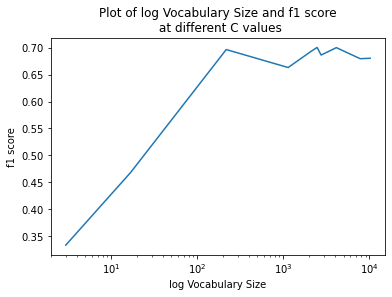

In [8]:
# Show a plot of f1 score vs. log vocabulary size

def plot_accuracy_vocab(Cs):
    vocab_size_list = list()
    accuracy_list = list()
    
    results = np.array(['C', 'Vocabulary Size', 'l2 Accuracy'])
    
    for c in Cs:
        np.random.seed(0)
        cv = CountVectorizer()

        transformed_train_data = cv.fit_transform(train_data)
        transformed_dev_data = cv.transform(dev_data)

        # Number of non-zero for 'l1' penalty
        logit_model = LogisticRegression(C=c, penalty='l1', tol=.015, solver='liblinear')
        logit_model.fit(transformed_train_data, train_labels)
        
        #Sum of each weight over all the classes
        sum_of_weights_over_all_classes = np.sum(logit_model.coef_ != 0, axis = 0)
        indices_with_nonzero_weight_sum = np.where(sum_of_weights_over_all_classes > 0)
        reduced_vocabulary = np.array(cv.get_feature_names())[indices_with_nonzero_weight_sum[0]]
        reduced_vocabulary = set(reduced_vocabulary)
        
        # Calculating accuracy for 'l2' penalty.
        cv = CountVectorizer(vocabulary = reduced_vocabulary)
        transformed_train_data = cv.fit_transform(train_data)
        transformed_dev_data = cv.transform(dev_data)
    
        logit_model_new = LogisticRegression(penalty='l2', tol=.015, solver='liblinear')
        logit_model_new.fit(transformed_train_data, train_labels)
        #accuracy_score = logit_model_new.score(transformed_dev_data, dev_labels)
        logit_model_preds = logit_model_new.predict(transformed_dev_data)
        accuracy_score = metrics.f1_score(y_true = dev_labels, y_pred = logit_model_preds, average="weighted")

        results = np.vstack((results, np.array([c, len(reduced_vocabulary), accuracy_score])))
        
    np.set_printoptions(linewidth=100, formatter={'all':lambda x: '{0}'.format(str(x).rjust(18))})
    print (results)
    
    plt.figure()
    plt.xscale("log")
    plt.plot(results[1:, 1].astype(float), results[1:, 2].astype(float))
    plt.xlabel('log Vocabulary Size')
    plt.ylabel('f1 score')
    plt.title('Plot of log Vocabulary Size and f1 score\n at different C values')
    

def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    ### STUDENT START ###
    
    cv = CountVectorizer()
    transformed_train_data = cv.fit_transform(train_data)
    transformed_dev_data = cv.transform(dev_data)
    
    # Number of non-zero for 'l1' penalty
    logit_model = LogisticRegression(penalty='l1', tol=0.015, solver='liblinear')
    logit_model.fit(transformed_train_data, train_labels)
    print ("Number of non-zero learned weights for 'l1' penalty =", np.sum(logit_model.coef_ != 0))
    l1_weights = logit_model.coef_
 
    # Number of non-zero for 'l2' penalty
    logit_model = LogisticRegression(penalty='l2', tol=0.015, solver='liblinear')
    logit_model.fit(transformed_train_data, train_labels)
    print ("Number of non-zero learned weights for 'l2' penalty =", np.sum(logit_model.coef_ != 0))
    
    # Creating reduced vocabulary with non-zero weights in 'l1'
    sum_of_weights_over_all_classes = np.sum(l1_weights != 0, axis = 0)
    indices_with_nonzero_weight_sum = np.where(sum_of_weights_over_all_classes > 0)
    reduced_vocabulary = np.array(cv.get_feature_names())[indices_with_nonzero_weight_sum[0]]
    reduced_vocabulary = set(reduced_vocabulary)
    print ("\nReduced vocabulary i.e. Number of features that have at least one non-zero weight =", len(reduced_vocabulary))
    
    # Re-training logistic regression with reduced vocabulary
    cv = CountVectorizer(vocabulary = reduced_vocabulary)
    transformed_train_data = cv.fit_transform(train_data)
    transformed_dev_data = cv.transform(dev_data)

    logit_model_new = LogisticRegression(penalty='l2', tol=.015, solver='liblinear')
    logit_model_new.fit(transformed_train_data, train_labels)
    print ("With reduced vocabulary, number of non-zero learned weights for 'l2' penalty =", np.sum(logit_model_new.coef_ != 0))
    ### STUDENT END ###

P6()

Cs = [0.001, 0.01, 0.1, 1.0, 2.0, 5.0, 10.0, 20.0, 50.0, 100.0]
plot_accuracy_vocab(Cs)

ANSWER:

**Compared to l2 penalty, l1 penalty results in significantly less number of non-zero weights. l1 penalty produced 1951 non-zero weights while l2 penalty did not produce any weight equal to zero.**

### Part 7:

How is `TfidfVectorizer` different than `CountVectorizer`?

Produce a Logistic Regression model based on data represented in tf-idf form, with L2 regularization strength of 100.  Evaluate and show the f1 score.  How is `TfidfVectorizer` different than `CountVectorizer`?

Show the 3 documents with highest R ratio, where ...<br/>
$R\,ratio = maximum\,predicted\,probability \div predicted\,probability\,of\,correct\,label$

Explain what the R ratio describes.  What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

Note:
* Train on the transformed training data.
* Evaluate on the transformed development data.
* You can use `TfidfVectorizer` and its `.fit_transform` method to transform data to tf-idf form.
* You can use `LogisticRegression(C=100, solver="liblinear", multi_class="auto")` to produce a logistic regression model.
* You can use `LogisticRegression`'s `.predict_proba` method to access predicted probabilities.

In [9]:
def P7():
    ### STUDENT START ###
    tv = TfidfVectorizer()
    transformed_train_data = tv.fit_transform(train_data)
    transformed_dev_data = tv.transform(dev_data)
    
    # Creating a Logistic Regression model 
    logit_model = LogisticRegression(C=100, penalty='l2', multi_class="auto", solver='liblinear')
    logit_model.fit(transformed_train_data, train_labels)
    
    # Calculating f1 score
    logit_model_preds = logit_model.predict(transformed_dev_data)
    f1 = metrics.f1_score(y_true = dev_labels, y_pred = logit_model_preds, average="weighted")
    print ("f1-score using TfidfVectorizer is {0:.3f}\n".format(f1))
    
    # Access predicted probabilities
    logit_model_probs_preds = logit_model.predict_proba(transformed_dev_data)
    
    # Calculating R
    R = list()
    for i in range(len(dev_labels)):
        max_probability = logit_model_probs_preds[i].max()
        pred_probability_correct_label = logit_model_probs_preds[i][dev_labels[i]]
        R.append(max_probability / pred_probability_correct_label)
    R = np.array(R)
    R_sorted_indices = np.argsort(R)
    largest_3_R = R_sorted_indices[-3 : len(R_sorted_indices)]

    # Printing top 3 documents with largest R
    for r in largest_3_R:
        print (">> Ratio R = {0:.2f}".format(R[r]))
        index_max_prob = np.argsort(logit_model_probs_preds[r])[-1]
        print (">> Class with maximum probability = '{0}' with probability = {1}".format(newsgroups_train.target_names[index_max_prob], logit_model_probs_preds[r].max()))
        print (">> Predicted Probability of correct label '{0}' = {1}".format(newsgroups_train.target_names[dev_labels[r]], logit_model_probs_preds[r][dev_labels[r]]))
        print (">> Document:")
        print (dev_data[r])
        print ("- - *** - -\n")
    
    # Printing Confusion matrix
    np.set_printoptions()
    cm = confusion_matrix(logit_model_preds, dev_labels)
    print (newsgroups_train.target_names)
    print (cm)
    
    
    ### STUDENT END ###

P7()

f1-score using TfidfVectorizer is 0.760

>> Ratio R = 287.18
>> Class with maximum probability = 'talk.religion.misc' with probability = 0.6954624801938017
>> Predicted Probability of correct label 'alt.atheism' = 0.002421704341655966
>> Document:

The 24 children were, of course, killed by a lone gunman in a second story
window, who fired eight bullets in the space of two seconds...

- - *** - -

>> Ratio R = 325.00
>> Class with maximum probability = 'comp.graphics' with probability = 0.9797463201589458
>> Predicted Probability of correct label 'talk.religion.misc' = 0.0030145676609597016
>> Document:
Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.
- - *** - -

>> Ratio R = 929.36
>> Class with maximum probability = 'comp.graphics' with probability = 0.9937199383102715
>> Predicted Probability of correct label 'talk.religion.misc' = 0.0010692551480208303
>> Document:
I am pleased to announce th

ANSWER:

CountVectorizer creates a matrix where each cell represents the number of times the feature has appeared in a document. Whereas, TfidfVectorizer creates a matrix where each cell represents the Tf-idf weight of each feature in the document.

Tf-idf of a feature is calculated in the following way: Term frequency X Inverse Document Frequency.

- Term Frequency = number of times a word appeared in a document / total number of words in the document

- Inverse Document Frequency = Log_e(total number of documents / number of documents in which the word appears).

Therefore, Tf-idf reduces the importance of common features.

**What kind of mistakes is the model making:**

As we can see from the Confusion Matrix, most errors are between 'talk.religion.misc' and 'alt.atheism'. From the label names it seems that words that are important to one label will be important to the other label as well. Hence the classifier is making errors. There are also several errors between 'comp.graphics' and 'alt.atheism'. The errors between 'comp.graphics' and 'alt.atheism' are caused by the presense of 'computer like' words such as internet, download and ftp.

**Ways to address issues:**
To solve errors between 'talk.religion.misc' and 'alt.atheism', we can do the following:

- Remove stopwords
- Use the max_df parameter to to set corpus specific stop words

To solve the errors between 'comp.graphics' and 'alt.atheism', we can do the following:

- Use grammar recognition and give more weights to object of the sentences and less weight to other words.


### Part 8 EXTRA CREDIT:

Produce a Logistic Regression model to implement your suggestion from Part 7.

In [10]:
def P8():
    tv = TfidfVectorizer(stop_words='english', max_df = 100)
    
    transformed_train_data = tv.fit_transform(train_data)
    transformed_dev_data = tv.transform(dev_data)
    
    logit_model = LogisticRegression(C=100, penalty='l2', solver='liblinear')
    logit_model.fit(transformed_train_data, train_labels)
    logit_model.preds = logit_model.predict(transformed_dev_data)
    print ("Accuracy of logistic Regression using TfidfVectorizer is {0:.3f}\n".format(logit_model.score(transformed_dev_data, dev_labels)))
    
    # Printing Confusion matrix
    np.set_printoptions()
    cm = confusion_matrix(logit_model.preds, dev_labels)
    print (newsgroups_train.target_names)
    print (cm)
    
P8()

Accuracy of logistic Regression using TfidfVectorizer is 0.780

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
[[ 98   3   8  20]
 [  5 166   7   9]
 [ 26  15 182  17]
 [ 36   1   2  81]]



From the confusion matrix in #P7 we see that the number of errors between 'talk.religion.misc' and 'alt.atheism' was 33 + 31 = 64 with an overall accuracy of 0.76.

By applying `english` stopwords and `corpus` specific stop words (by using the max_df parameter), the errors between 'talk.religion.misc' and 'alt.atheism' has reduced to 36 + 20 = 56 and overall accuracy has increased to 0.78